In [2]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
import xgcm
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *



from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

In [3]:
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft

In [4]:
%time depthToZlayer(200)

CPU times: user 14.8 ms, sys: 8.01 ms, total: 22.8 ms
Wall time: 32.2 ms


28

In [5]:
def _e1e2(navlon,navlat):
    earthrad = 6371229     # mean earth radius (m)

    deg2rad = np.pi / 180.

    lam = navlon

    phi = navlat

    djlam,dilam = np.gradient(lam)

    djphi,diphi = np.gradient(phi)

    e1 = earthrad * deg2rad * np.sqrt( (dilam * np.cos(deg2rad*phi))**2. + diphi**2.)

    e2 = earthrad * deg2rad * np.sqrt( (djlam * np.cos(deg2rad*phi))**2. + djphi**2.)

    return e1,e2

 

#########################
"""
Perform a spatial interpolation if required; return da_reg (km/m and days/hrs coordinates)
da - array with lat, lon, time (degrees and hours)
"""
def regularizeCoordinates(da,interp=None, timeunits='days', spaceunits ='km'):
    davals = da.values
    time = da.time.values
    lon = da.lon.values
    lat = da.lat.values
    lon_mesh,lat_mesh = np.meshgrid(lat, lon)
    e1,e2 = _e1e2(lon_mesh,lat_mesh)

    if ( spaceunits== 'km'):
        length_factor = 1000
    else:
        length_factor = 1
        
    if ( timeunits == 'days' ):
        time_factor = 24
    else:
        time_factor = 1
    x1d_in = (e1[0,:].cumsum() - e1[0,0] ) / length_factor # convert from m to km

    y1d_in = (e2[:,0].cumsum() - e2[0,0] ) / length_factor # convert from m to km
    
    da_met = xr.DataArray(data = davals, dims = ['time','xdim','ydim'], coords=[time / time_factor, x1d_in, y1d_in])
    
    if interp is not None:
        x1d_new = np.linspace(x1d_in.min(), x1d_in.max(), len(x1d_in))
        y1d_new = np.linspace(y1d_in.min(), y1d_in.max(), len(y1d_in))
        da_reg = da_met.interp(xdim = x1d_new, ydim = y1d_new, method=interp)
    #x2d_in,y2d_in = np.meshgrid(x1d_in,y1d_in)
    else:
        da_reg = da_met
   
    return da_reg #we can work on getting this to interpolate next

In [6]:
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland_attempt2/', 'Theta', 15,15 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [7]:
T15c = T15.compute()
T15c

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.03 20.03 20.06 ... 15.25 15.21 15.26

In [8]:
W = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/', 'W', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer


In [9]:
Wc = W.compute()
Wc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    W        (time, lat, lon) float64 -0.0001791 -0.0001791 ... 5.382e-05

In [10]:
Theta15 = T15c.Theta
W15 = Wc.W

In [11]:
Theta15

<xarray.DataArray 'Theta' (time: 2208, lat: 300, lon: 375)>
array([[[20.03393936, 20.03393936, 20.05987549, ..., 20.07913017,
         20.11499786, 20.10113144],
        [20.0337429 , 20.0337429 , 20.04794693, ..., 20.07556152,
         20.11726761, 20.10302162],
        [20.03877068, 20.03877068, 20.04024124, ..., 20.08831024,
         20.11519623, 20.10379028],
        ...,
        [ 9.50843906,  9.50843906,  9.49765587, ..., 14.62988758,
         14.61009407, 14.59073544],
        [ 9.64250469,  9.64250469,  9.61566925, ..., 14.45315361,
         14.45778275, 14.46081638],
        [10.18348598, 10.18348598, 10.12649059, ..., 14.34997654,
         14.35819054, 14.36782169]],

       [[20.03316498, 20.03316498, 20.06603813, ..., 20.08368874,
         20.11501312, 20.10103607],
        [20.03221321, 20.03221321, 20.05183029, ..., 20.07873154,
         20.11715317, 20.10276794],
        [20.03635406, 20.03635406, 20.04163742, ..., 20.09045601,
         20.11499977, 20.10357475],
...
        [13.47716427, 13.47716427, 13.62457371, ..., 15.22689819,
         15.16504765, 15.27029514],
        [13.56757164, 13.56757164, 13.71325207, ..., 15.26884174,
         15.20705032, 15.27132607],
        [13.69296646, 13.69296646, 13.81317997, ..., 15.26718616,
         15.21602631, 15.26326561]],

       [[20.59471512, 20.59471512, 20.63847542, ..., 20.28848839,
         20.44502068, 20.21613121],
        [20.64384651, 20.64384651, 20.71489716, ..., 20.3376255 ,
         20.42549324, 20.25374603],
        [20.71295738, 20.71295738, 20.71903992, ..., 20.19218826,
         20.24973869, 20.28374481],
        ...,
        [13.43190861, 13.43190861, 13.59977341, ..., 15.23666954,
         15.16348839, 15.25693226],
        [13.51799202, 13.51799202, 13.69208145, ..., 15.2660923 ,
         15.21285534, 15.27589893],
        [13.63515568, 13.63515568, 13.80089664, ..., 15.25488758,
         15.2074852 , 15.26331234]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [12]:
Theta15_i = Theta15.interp(lon = W15.lon, method = 'linear')

In [13]:
Theta15_i

<xarray.DataArray 'Theta' (time: 2208, lat: 300, lon: 375)>
array([[[20.03393936, 20.03393936, 20.05987549, ..., 20.07913017,
         20.11499786, 20.10113144],
        [20.0337429 , 20.0337429 , 20.04794693, ..., 20.07556152,
         20.11726761, 20.10302162],
        [20.03877068, 20.03877068, 20.04024124, ..., 20.08831024,
         20.11519623, 20.10379028],
        ...,
        [ 9.50843906,  9.50843906,  9.49765587, ..., 14.62988758,
         14.61009407, 14.59073544],
        [ 9.64250469,  9.64250469,  9.61566925, ..., 14.45315361,
         14.45778275, 14.46081638],
        [10.18348598, 10.18348598, 10.12649059, ..., 14.34997654,
         14.35819054, 14.36782169]],

       [[20.03316498, 20.03316498, 20.06603813, ..., 20.08368874,
         20.11501312, 20.10103607],
        [20.03221321, 20.03221321, 20.05183029, ..., 20.07873154,
         20.11715317, 20.10276794],
        [20.03635406, 20.03635406, 20.04163742, ..., 20.09045601,
         20.11499977, 20.10357475],
...
        [13.47716427, 13.47716427, 13.62457371, ..., 15.22689819,
         15.16504765, 15.27029514],
        [13.56757164, 13.56757164, 13.71325207, ..., 15.26884174,
         15.20705032, 15.27132607],
        [13.69296646, 13.69296646, 13.81317997, ..., 15.26718616,
         15.21602631, 15.26326561]],

       [[20.59471512, 20.59471512, 20.63847542, ..., 20.28848839,
         20.44502068, 20.21613121],
        [20.64384651, 20.64384651, 20.71489716, ..., 20.3376255 ,
         20.42549324, 20.25374603],
        [20.71295738, 20.71295738, 20.71903992, ..., 20.19218826,
         20.24973869, 20.28374481],
        ...,
        [13.43190861, 13.43190861, 13.59977341, ..., 15.23666954,
         15.16348839, 15.25693226],
        [13.51799202, 13.51799202, 13.69208145, ..., 15.2660923 ,
         15.21285534, 15.27589893],
        [13.63515568, 13.63515568, 13.80089664, ..., 15.25488758,
         15.2074852 , 15.26331234]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [14]:
Theta15_reg = regularizeCoordinates(Theta15_i,'linear',timeunits = 'hours')
W15_reg = regularizeCoordinates(W15, 'linear', timeunits = 'hours')

In [15]:
Theta15_reg.to_netcdf('/nobackup/amondal/NCData/Theta15_reg_for_Hector.nc4')
W15_reg.to_netcdf('/nobackup/amondal/NCData/W15_reg_for_Hector.nc4')

In [16]:
Theta15_reg.ydim.diff('ydim').mean()

<xarray.DataArray 'ydim' ()>
array(4.44795694)

In [17]:
Theta15_reg_w = Theta15_reg[0:1250]
Theta15_reg_s = Theta15_reg[1251:]
W15_reg_w = W15_reg[0:1250]
W15_reg_s = W15_reg[1251:]

In [18]:
Theta15_reg_w.xdim.diff('xdim').mean()

<xarray.DataArray 'xdim' ()>
array(2.22397847)

In [19]:
Theta15_reg2_w = xrft.detrend(Theta15_reg_w, dim = ['time'], detrend_type = 'linear')
W15_reg2_w = xrft.detrend(W15_reg_w, dim = 'time', detrend_type = 'linear')
Theta15_reg3_w = xrft.detrend(Theta15_reg2_w, dim = ['xdim','ydim'], detrend_type = 'linear')
W15_reg3_w = xrft.detrend(W15_reg2_w, dim = ['xdim','ydim'], detrend_type = 'linear')

Theta15_reg2_s = xrft.detrend(Theta15_reg_s, dim = ['time'], detrend_type = 'linear')
W15_reg2_s = xrft.detrend(W15_reg_s, dim = 'time', detrend_type = 'linear')
Theta15_reg3_s = xrft.detrend(Theta15_reg2_s, dim = ['xdim','ydim'], detrend_type = 'linear')
W15_reg3_s = xrft.detrend(W15_reg2_s, dim = ['xdim','ydim'], detrend_type = 'linear')

Lx_w = Theta15_reg3_w.xdim.size
Ly_w = Theta15_reg3_w.ydim.size
Lt_w = Theta15_reg3_w.time.size

Lx_s = Theta15_reg3_s.xdim.size
Ly_s = Theta15_reg3_s.ydim.size
Lt_s = Theta15_reg3_s.time.size

dx_w = Theta15_reg3_w.xdim.diff('xdim').mean()
dy_w = Theta15_reg3_w.ydim.diff('ydim').mean()
dt_w = Theta15_reg3_w.time.diff('time').mean()

dx_s = Theta15_reg3_s.xdim.diff('xdim').mean()
dy_s = Theta15_reg3_s.ydim.diff('ydim').mean()
dt_s = Theta15_reg3_s.time.diff('time').mean()
"""
Lx_w = Theta15_reg2_w.xdim.max() - Theta15_reg2_w.xdim.min()
Ly_w = Theta15_reg2_w.ydim.max() - Theta15_reg2_w.ydim.min()
Lt_w = Theta15_reg2_w.time.max() - Theta15_reg2_w.time.min()

Lx_s = Theta15_reg2_s.xdim.max() - Theta15_reg2_s.xdim.min()
Ly_s = Theta15_reg2_s.ydim.max() - Theta15_reg2_s.ydim.min()
Lt_s = Theta15_reg2_s.time.max() - Theta15_reg2_s.time.min()
"""

'\nLx_w = Theta15_reg2_w.xdim.max() - Theta15_reg2_w.xdim.min()\nLy_w = Theta15_reg2_w.ydim.max() - Theta15_reg2_w.ydim.min()\nLt_w = Theta15_reg2_w.time.max() - Theta15_reg2_w.time.min()\n\nLx_s = Theta15_reg2_s.xdim.max() - Theta15_reg2_s.xdim.min()\nLy_s = Theta15_reg2_s.ydim.max() - Theta15_reg2_s.ydim.min()\nLt_s = Theta15_reg2_s.time.max() - Theta15_reg2_s.time.min()\n'

In [20]:
Theta_time_w = (Theta15_reg3_s * W15_reg3_s * 4.2*10**6).mean('time')

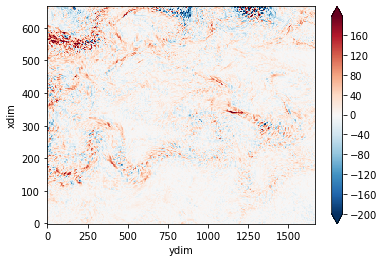

In [21]:
%matplotlib inline
levels = np.arange(-200, 200, 2)
Theta_time_w.plot(levels = levels)


In [22]:
Theta_time_w_space = (Theta15_reg3_s * W15_reg3_s * 4.2*10**6).mean(['xdim', 'ydim'])

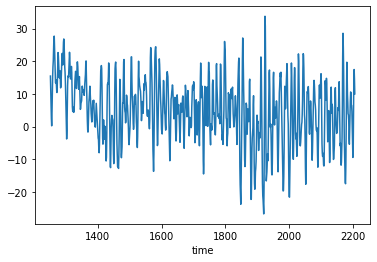

In [23]:
%matplotlib inline 
Theta_time_w_space.plot()

In [24]:
Theta_time_w_spacetime = (Theta15_reg3_s * W15_reg3_s * 4.2*10**6).mean()
Theta_time_w_spacetime

<xarray.DataArray ()>
array(4.90301694)

In [25]:
Twin_15_w,T15_win_w = xrft.xrft._apply_window(Theta15_reg3_w,['xdim','ydim','time'], window_type='hann')
Wwin_15_w,W15_win_w = xrft.xrft._apply_window(W15_reg3_w ,['xdim','ydim','time'], window_type='hann')
_,T15_win_s = xrft.xrft._apply_window(Theta15_reg3_s,['xdim','ydim','time'], window_type='tukey')
_,W15_win_s = xrft.xrft._apply_window(W15_reg3_s ,['xdim','ydim','time'], window_type='tukey')

In [26]:
(Twin_15_w*Wwin_15_w).mean()

<xarray.DataArray ()>
array(0.05273438)

In [27]:
crosspec15_w = 0.5*xrft.cross_spectrum(Theta15_reg3_w, W15_reg3_w , dim=["xdim","ydim","time"], real_dim="time",true_phase = True, true_amplitude=True, truncate=True, window="hann")
crosspec15_w_cor = crosspec15_w.sortby(["freq_ydim", "freq_xdim"])
#I took out the real dim line

In [28]:
from spectral_analysis_code import *
Qp15_w_iso = isotropize(np.real(crosspec15_w_cor), ['freq_xdim', 'freq_ydim'], 'freq_time')  / (Twin_15_w*Wwin_15_w).mean()

In [29]:
crosspec15_w_cor

<xarray.DataArray (freq_time: 626, freq_xdim: 300, freq_ydim: 375)>
array([[[ 2.87780159e-07-4.43431311e-07j,
          3.23766891e-07-8.48407923e-07j,
         -6.30720120e-07+5.15613736e-07j, ...,
         -6.30720120e-07-5.15613736e-07j,
          3.23766891e-07+8.48407923e-07j,
          2.87780159e-07+4.43431311e-07j],
        [ 2.29437600e-07-4.33733916e-07j,
          9.61408115e-07-8.09091965e-07j,
         -7.99408495e-08-1.02875903e-06j, ...,
         -7.63880029e-08+5.34460736e-08j,
         -2.65070370e-07+8.74705698e-08j,
         -8.49226646e-08-6.08237027e-09j],
        [ 1.80343743e-08+3.81652831e-08j,
          6.11507995e-07-2.20244104e-07j,
          1.25910148e-06-1.35962109e-06j, ...,
          3.14436465e-07-1.76893555e-07j,
          3.43470147e-07-2.78803269e-07j,
          4.09409203e-08-2.46432274e-07j],
        ...,
        [-3.01811206e-07-3.90588411e-08j,
...
         -4.33430899e-11+1.07737607e-10j],
        ...,
        [ 3.86726046e-11-1.10383238e-10j,
          7.46457864e-10+8.87315323e-10j,
          2.95174881e-10+9.39766530e-10j, ...,
         -3.16664102e-10+4.11377986e-12j,
         -1.60729171e-10+6.37873911e-10j,
          2.82865742e-10+3.15165672e-10j],
        [-4.33430899e-11-1.07737607e-10j,
          5.46254326e-10-2.41589237e-11j,
          6.32576495e-10+5.03228991e-10j, ...,
          3.17273637e-11-6.37111736e-10j,
         -3.15846578e-10+2.30493399e-11j,
         -2.11592612e-10+2.15612063e-10j],
        [-2.98200384e-11+2.79263569e-11j,
         -2.54599474e-11-4.72051029e-10j,
         -3.26524451e-11-7.55322216e-10j, ...,
         -8.70856721e-11+1.28340247e-11j,
         -4.66151865e-11+1.28958244e-10j,
         -2.72148860e-11-2.08920949e-11j]]])
Coordinates:
  * freq_xdim  (freq_xdim) float64 -0.2248 -0.2233 -0.2218 ... 0.2218 0.2233
  * freq_ydim  (freq_ydim) float64 -0.1121 -0.1115 -0.1109 ... 0.1115 0.1121
  * freq_time  (freq_time) float64 0.0 0.0008 0.0016 ... 0.4984 0.4992 0.5

ISOTROPIC_CROSS_SPECTRUM doesn't work unless we transform xdim and ydim to rdim before the fft


Also, if you ask it to chunk in one dimension, it default chunks in all dimensions - so don't bother trying to do all 3 dimensions at once

In [30]:
T15_w = xrft.xrft.fft(Theta15_reg3_w, dim = ['ydim'], real_dim = 'ydim', window = 'tukey',  true_amplitude = True, true_phase = True, truncate = True, )
W15_w = xrft.xrft.fft(W15_reg3_w, dim = ['ydim'], real_dim = 'ydim',  window = 'tukey',  true_amplitude = True,  true_phase = True,truncate = True, )
T15_w2 = xrft.xrft.fft(T15_w, dim= 'xdim', real_dim = 'xdim', window = 'tukey',  true_amplitude = True, true_phase = True,truncate = True, )
W15_w2 = xrft.xrft.fft(W15_w, dim= 'xdim', real_dim = 'xdim', window = 'tukey', true_amplitude = True, true_phase = True,truncate = True, )
window1, _ = xrft.xrft._apply_window(Theta15_reg3_w, 'ydim', window_type='tukey')
window2, _ = xrft.xrft._apply_window(T15_w, 'xdim',window_type='tukey')
T15_s = xrft.xrft.fft(Theta15_reg3_s, dim = ['ydim'], real_dim = 'ydim', window = 'tukey', true_amplitude = True, true_phase = True,truncate = True, )
W15_s = xrft.xrft.fft(W15_reg3_s, dim = ['ydim'], real_dim = 'ydim',  window = 'tukey', true_amplitude = True,  true_phase = True,truncate = True, )
T15_s2 = xrft.xrft.fft(T15_s, dim= 'xdim', real_dim = 'xdim', window = 'tukey', true_amplitude = True, true_phase = True,truncate = True, )
W15_s2 = xrft.xrft.fft(W15_s, dim= 'xdim', real_dim = 'xdim', window = 'tukey', true_amplitude = True, true_phase = True,truncate = True, )



In [31]:
Lx_w

300

In [32]:
T15_s2.time.size

957

In [33]:
"""
# let's attempt Welch's method:
Tn_w = T15_w.time.size
Wn_w = W15_w.time.size
segsize = 7
easychunknum = (segsize + 1) / 2
overlapnum = easychunknum - 1
length = int(Tn_w / easychunknum)
append_da = T15_w[int(easychunknum / 2): int(easychunknum / 2) + length * overlapnum]
T15_w_append = xr.concat([T15_w, append_da], compat = "identical", dim='time')
#finish welch's method off
"""
"""
# this does Bartlett's method 
Tn_w = T15_w2.time.size
Wn_w = W15_w2.time.size
T15_wkl_w = xrft.xrft.fft(T15_w2.chunk({'time':int(Tn_w/5)}), dim = 'time', real_dim = 'time', window = 'tukey', window_correction = True, true_amplitude = True, truncate = True, chunks_to_segments=True).compute()
W15_wkl_w = xrft.xrft.fft(W15_w2.chunk({'time':int(Wn_w/5)}), dim = 'time', real_dim = 'time',  window = 'tukey', window_correction = True, true_amplitude = True,  truncate = True, chunks_to_segments=True).compute()


Tn_s = T15_s2.time.size
Wn_s = W15_s2.time.size
T15_wkl_s = xrft.xrft.fft(T15_s2[0:955].chunk({'time':int(Tn_s/5)}), dim = 'time', real_dim = 'time', window = 'tukey', window_correction = True, true_amplitude = True, truncate = True, chunks_to_segments=True).compute()
W15_wkl_s = xrft.xrft.fft(W15_s2[0:955].chunk({'time':int(Wn_s/5)}), dim = 'time', real_dim = 'time',  window = 'tukey', window_correction = True, true_amplitude = True,  truncate = True, chunks_to_segments=True).compute()
"""
T15_wkl_w = xrft.xrft.fft(T15_w2, dim = 'time', real_dim = 'time', window = 'tukey', true_amplitude = True, true_phase = True,truncate = True).compute()
W15_wkl_w = xrft.xrft.fft(W15_w2, dim = 'time', real_dim = 'time',  window = 'tukey', true_amplitude = True,  true_phase = True,truncate = True).compute()
window3, _ = xrft.xrft._apply_window(T15_w2, 'time', window_type='tukey')
dkw = T15_wkl_w.freq_xdim.diff('freq_xdim').mean()
dlw = T15_wkl_w.freq_ydim.diff('freq_ydim').mean()
domw = T15_wkl_w.freq_time.diff('freq_time').mean()

T15_wkl_s = xrft.xrft.fft(T15_s2[0:955], dim = 'time', real_dim = 'time', window = 'tukey', true_amplitude = True,true_phase = True, truncate = True).compute()
W15_wkl_s = xrft.xrft.fft(W15_s2[0:955], dim = 'time', real_dim = 'time',  window = 'tukey', true_amplitude = True,true_phase = True,  truncate = True).compute()
dks = T15_wkl_s.freq_xdim.diff('freq_xdim').mean()
dls = T15_wkl_s.freq_ydim.diff('freq_ydim').mean()
doms = T15_wkl_s.freq_time.diff('freq_time').mean()

In [34]:
T15_w2

<xarray.DataArray (time: 1250, freq_xdim: 151, freq_ydim: 188)>
array([[[-8.76133961e+02+0.00000000e+00j,
          8.29548329e+02+0.00000000e+00j,
         -2.08569609e+01+0.00000000e+00j, ...,
         -3.03958044e+00+0.00000000e+00j,
          5.44585528e+00+0.00000000e+00j,
         -1.89305651e+00+0.00000000e+00j],
        [-3.63691872e+02+3.14784994e+02j,
         -8.70883227e+01-1.18314922e+03j,
          1.74821459e+02+1.49925029e+02j, ...,
          7.51712257e-01-4.36900071e+00j,
         -3.63183648e+00-2.52626887e+00j,
          3.78885523e+00+1.56791186e+00j],
        [ 8.80389660e+02-1.55494228e+02j,
         -3.77427800e+02+1.17396933e+03j,
         -1.55116418e+02-3.63259132e+02j, ...,
         -1.58992679e+00-9.04134348e-01j,
          7.51560548e-01+9.00535449e-01j,
         -2.09394151e+00+3.39857692e+00j],
        ...,
        [ 6.19939785e+00-5.27761464e+00j,
...
          1.35718670e+00+2.01456843e-01j],
        ...,
        [-8.76569498e+00+1.04468386e+01j,
         -9.16971442e+00+7.29267924e+00j,
          5.41402215e+00-1.63861382e+01j, ...,
          2.54313000e-01-2.29272338e+00j,
         -1.29505108e+00+1.87283793e+00j,
          8.00427071e-01-2.31222675e-01j],
        [ 1.62632690e+00-1.80546820e+01j,
         -1.52686641e-01-2.87070347e+00j,
         -3.34627464e+00+1.39634320e+01j, ...,
         -2.13997902e-02+2.81882800e+00j,
          2.74238293e-01+3.53568966e-01j,
          2.09102542e-01-1.17788391e+00j],
        [ 9.16925791e+00+0.00000000e+00j,
         -2.96371388e+00+0.00000000e+00j,
          1.01105899e+01+0.00000000e+00j, ...,
         -1.32376294e-01+0.00000000e+00j,
          1.48012009e-01+0.00000000e+00j,
         -8.85335674e-01+0.00000000e+00j]]])
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 1.247e+03 1.248e+03 1.249e+03
  * freq_ydim  (freq_ydim) float64 0.0 0.0005995 0.001199 ... 0.1115 0.1121
  * freq_xdim  (freq_xdim) float64 0.0 0.001499 0.002998 ... 0.2233 0.2248

In [35]:
T15_wkl_w_conj = np.conjugate(T15_wkl_w)
T15_wkl_s_conj = np.conjugate(T15_wkl_s)

In [36]:
Qp15_w = 2*W15_wkl_w * T15_wkl_w_conj * (dkw * dlw * domw) #/ ((window1*window2*window3)**2).mean()# / (Lx_w * Ly_w * Lt_w)#/ (Lx_w * Ly_w * Lt_w)**2 / (dkw * dlw * domw)**2  #include normalization
Qp15_s = W15_wkl_s * T15_wkl_s_conj * (dks * dls * doms)  # / (Lx_s * Ly_s * Lt_s)#/ (Lx_s * Ly_s * Lt_s)**2 / (dks * dls * doms)**2

In [37]:
# norm for Plancherel's theorem check
KNorm_w = np.real(Qp15_w.sum()) #/ (Lx_w * Ly_w * Lt_w)
KNorm_s = np.real(Qp15_s.sum()) #/ (Lx_s * Ly_s * Lt_s)

In [38]:
%%time 
Qpc15_w = Qp15_w#.mean('time_segment')
Qpc15_s = Qp15_s#.mean('time_segment')

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 17.6 µs


In [39]:
#Qp15_w_iso = xrft.xrft.isotropize(np.real(Qpc15_w), ['freq_xdim', 'freq_ydim'], truncate = True)
Qp15_s_iso = xrft.xrft.isotropize(np.real(Qpc15_s), ['freq_xdim', 'freq_ydim'], truncate = True)

In [40]:
Qp15_w_iso

<xarray.DataArray (freq_time: 626, freq_r: 70)>
array([[-1.56897326e-03, -1.25874128e-03,  7.79602098e-04, ...,
         9.52317364e-05,  1.11457154e-04,  1.19547459e-04],
       [-3.35563830e-03, -1.53183823e-03,  1.70195304e-03, ...,
         5.46751695e-04,  5.12449112e-04,  5.41947518e-04],
       [-8.01835265e-05,  5.26673064e-04,  2.42364161e-03, ...,
         8.74007401e-04,  7.82413788e-04,  7.25653126e-04],
       ...,
       [ 7.90250685e-09,  5.32579590e-10,  3.65719140e-11, ...,
        -2.41447824e-09,  1.17698400e-09,  1.78795463e-09],
       [-1.43467080e-09, -1.99151529e-09, -1.62838026e-09, ...,
        -1.47922078e-09,  1.25100177e-09, -3.45081400e-10],
       [-4.02052193e-09, -3.60731205e-10, -5.63211480e-10, ...,
        -6.64663198e-10, -3.04939128e-11,  2.09013977e-10]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 0.0008 0.0016 ... 0.4984 0.4992 0.5
  * freq_r     (freq_r) float64 0.0008071 0.002421 0.004036 ... 0.1106 0.1122

In [41]:
Eisop15_w = Qp15_w_iso.values[1:]
omp15_w = Qp15_w_iso.freq_time[1:].values
#kisop15_w = Qp15_w_iso.freq_r.values
kisop15_w = Qp15_w_iso.freq_r.values

Eisop15_s = Qp15_s_iso.values[1:]
omp15_s = Qp15_s_iso.freq_time[1:].values
kisop15_s = Qp15_s_iso.freq_r.values

In [42]:
rhoConst = 1027.5 #kg/m^3
Cp = 4.185*(10**3) # J / (kg K)

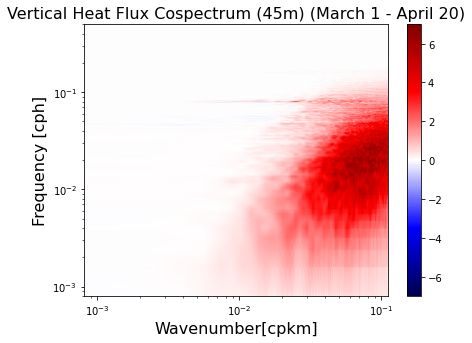

In [43]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs = plt.pcolormesh(kisop15_w, omp15_w, (Cp*rhoConst*1*Eisop15_w*kisop15_w[None,...]*omp15_w[...,None]), shading='gouraud', cmap='seismic')#, norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Heat Flux Cospectrum (45m) (March 1 - April 20)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([-7,7])
plt.colorbar()
plt.show()

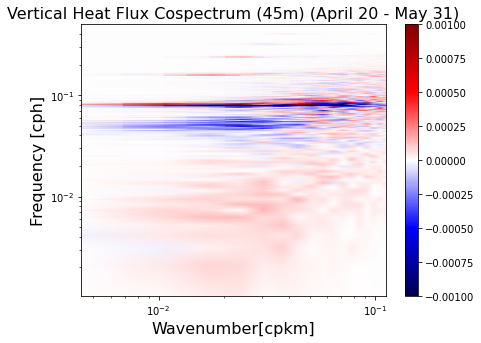

In [44]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs = plt.pcolormesh(kisop15_s, omp15_s, (Cp*rhoConst*1*Eisop15_s*kisop15_s[None,...]*omp15_s[...,None]), shading='gouraud', cmap='seismic')#, norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Heat Flux Cospectrum (45m) (April 20 - May 31)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([-.001, .001])
plt.colorbar()
plt.show()

In [45]:
T45 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/', 'Theta', 45,45 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [46]:
T45c = T45.compute()
T45c

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 11.9 11.9 11.85 ... 8.476 8.487 8.494

In [47]:
W = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/', 'W', 45,45)

Time combined dataset has been opened.
I concatenated the first Z-layer


In [48]:
Wc = W.compute()
Wc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    W        (time, lat, lon) float64 0.001633 0.001633 ... -0.001336 -0.002065

In [49]:
Theta45 = T45c.Theta
W45 = Wc.W

In [50]:
Theta15

<xarray.DataArray 'Theta' (time: 2208, lat: 300, lon: 375)>
array([[[20.03393936, 20.03393936, 20.05987549, ..., 20.07913017,
         20.11499786, 20.10113144],
        [20.0337429 , 20.0337429 , 20.04794693, ..., 20.07556152,
         20.11726761, 20.10302162],
        [20.03877068, 20.03877068, 20.04024124, ..., 20.08831024,
         20.11519623, 20.10379028],
        ...,
        [ 9.50843906,  9.50843906,  9.49765587, ..., 14.62988758,
         14.61009407, 14.59073544],
        [ 9.64250469,  9.64250469,  9.61566925, ..., 14.45315361,
         14.45778275, 14.46081638],
        [10.18348598, 10.18348598, 10.12649059, ..., 14.34997654,
         14.35819054, 14.36782169]],

       [[20.03316498, 20.03316498, 20.06603813, ..., 20.08368874,
         20.11501312, 20.10103607],
        [20.03221321, 20.03221321, 20.05183029, ..., 20.07873154,
         20.11715317, 20.10276794],
        [20.03635406, 20.03635406, 20.04163742, ..., 20.09045601,
         20.11499977, 20.10357475],
...
        [13.47716427, 13.47716427, 13.62457371, ..., 15.22689819,
         15.16504765, 15.27029514],
        [13.56757164, 13.56757164, 13.71325207, ..., 15.26884174,
         15.20705032, 15.27132607],
        [13.69296646, 13.69296646, 13.81317997, ..., 15.26718616,
         15.21602631, 15.26326561]],

       [[20.59471512, 20.59471512, 20.63847542, ..., 20.28848839,
         20.44502068, 20.21613121],
        [20.64384651, 20.64384651, 20.71489716, ..., 20.3376255 ,
         20.42549324, 20.25374603],
        [20.71295738, 20.71295738, 20.71903992, ..., 20.19218826,
         20.24973869, 20.28374481],
        ...,
        [13.43190861, 13.43190861, 13.59977341, ..., 15.23666954,
         15.16348839, 15.25693226],
        [13.51799202, 13.51799202, 13.69208145, ..., 15.2660923 ,
         15.21285534, 15.27589893],
        [13.63515568, 13.63515568, 13.80089664, ..., 15.25488758,
         15.2074852 , 15.26331234]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [51]:
Theta45_i = Theta45.interp(lon = W45.lon, method = 'linear')

In [52]:
Theta45_i

<xarray.DataArray 'Theta' (time: 2208, lat: 300, lon: 375)>
array([[[11.90219688, 11.90219688, 11.84714317, ..., 10.34654427,
         10.33419514, 10.44608688],
        [11.87849522, 11.87849522, 11.82749653, ..., 10.34324646,
         10.32232761, 10.4362793 ],
        [11.81390572, 11.81390572, 11.75345039, ..., 10.36865425,
         10.3413372 , 10.4683485 ],
        ...,
        [ 6.27528048,  6.27528048,  6.28128195, ...,  8.44972038,
          8.44069958,  8.39701748],
        [ 6.30907822,  6.30907822,  6.3155756 , ...,  8.34592342,
          8.29009151,  8.21792603],
        [ 6.33006334,  6.33006334,  6.33698225, ...,  8.16665554,
          8.14056873,  8.11894512]],

       [[11.71695518, 11.71695518, 11.66398335, ..., 10.32210159,
         10.32840633, 10.44195747],
        [11.71755886, 11.71755886, 11.67858505, ..., 10.29223728,
         10.30242634, 10.43440342],
        [11.69576645, 11.69576645, 11.64665318, ..., 10.32973576,
         10.33482838, 10.46037483],
...
        [ 6.52018404,  6.52018404,  6.49725199, ...,  8.37955666,
          8.3569479 ,  8.29135418],
        [ 6.50128603,  6.50128603,  6.46323919, ...,  8.38612747,
          8.35210133,  8.32419014],
        [ 6.49344063,  6.49344063,  6.43967962, ...,  8.43174171,
          8.40063477,  8.37398243]],

       [[10.55532169, 10.55532169, 10.48507118, ...,  9.729949  ,
          9.66950417,  9.60929203],
        [10.58985329, 10.58985329, 10.50474548, ...,  9.67323399,
          9.61982632,  9.58942986],
        [10.60741711, 10.60741711, 10.54945755, ...,  9.67994976,
          9.63052177,  9.60723877],
        ...,
        [ 6.44954491,  6.44954491,  6.45103216, ...,  8.42653847,
          8.43494415,  8.38621521],
        [ 6.43420935,  6.43420935,  6.42906761, ...,  8.45614624,
          8.46667004,  8.45362854],
        [ 6.42223787,  6.42223787,  6.41089916, ...,  8.47560215,
          8.48695278,  8.49357128]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [53]:
Theta45_reg = regularizeCoordinates(Theta45_i,'linear',timeunits = 'hours')
W45_reg = regularizeCoordinates(W45, 'linear', timeunits = 'hours')

In [54]:
Theta45_reg_w = Theta45_reg[0:1250]
Theta45_reg_s = Theta45_reg[1251:]
W45_reg_w = W45_reg[0:1250]
W45_reg_s = W45_reg[1251:]

In [55]:
Theta45_reg_w

<xarray.DataArray (time: 1250, xdim: 300, ydim: 375)>
array([[[11.90219688, 11.90219688, 11.84714317, ..., 10.34654427,
         10.33419514, 10.44608688],
        [11.87849522, 11.87849522, 11.82749653, ..., 10.34324646,
         10.32232761, 10.4362793 ],
        [11.81390572, 11.81390572, 11.75345039, ..., 10.36865425,
         10.3413372 , 10.4683485 ],
        ...,
        [ 6.27528048,  6.27528048,  6.28128195, ...,  8.44972038,
          8.44069958,  8.39701748],
        [ 6.30907822,  6.30907822,  6.3155756 , ...,  8.34592342,
          8.29009151,  8.21792603],
        [ 6.33006334,  6.33006334,  6.33698225, ...,  8.16665554,
          8.14056873,  8.11894512]],

       [[11.71695518, 11.71695518, 11.66398335, ..., 10.32210159,
         10.32840633, 10.44195747],
        [11.71755886, 11.71755886, 11.67858505, ..., 10.29223728,
         10.30242634, 10.43440342],
        [11.69576645, 11.69576645, 11.64665318, ..., 10.32973576,
         10.33482838, 10.46037483],
...
        [ 6.92794943,  6.92794943,  6.8994379 , ...,  8.44763374,
          8.51328468,  8.56524563],
        [ 6.82432604,  6.82432604,  6.79454279, ...,  8.5135088 ,
          8.57110691,  8.62066746],
        [ 6.74421692,  6.74421692,  6.70509005, ...,  8.65467548,
          8.68936539,  8.71582699]],

       [[10.60354519, 10.60354519, 10.52066994, ..., 10.65688038,
         10.72883129, 10.6426754 ],
        [10.58880234, 10.58880234, 10.49666119, ..., 10.73821354,
         10.72450638, 10.60822678],
        [10.59751892, 10.59751892, 10.48877811, ..., 10.7777729 ,
         10.72219181, 10.6142025 ],
        ...,
        [ 6.86765528,  6.86765528,  6.86244535, ...,  8.40938282,
          8.47974682,  8.54444885],
        [ 6.76257277,  6.76257277,  6.76315165, ...,  8.48542881,
          8.5487051 ,  8.59802151],
        [ 6.68346596,  6.68346596,  6.68489408, ...,  8.63549137,
          8.66902637,  8.6946249 ]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.247e+03 1.248e+03 1.249e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

In [56]:
Theta45_reg2_w = xrft.detrend(Theta45_reg_w, dim = ['time'], detrend_type = 'constant')
W45_reg2_w = xrft.detrend(W45_reg_w, dim = 'time', detrend_type = 'constant')
Theta45_reg3_w = xrft.detrend(Theta45_reg2_w, dim = ['xdim','ydim'], detrend_type = 'constant')
W45_reg3_w = xrft.detrend(W45_reg2_w, dim = ['xdim','ydim'], detrend_type = 'constant')

Theta45_reg2_s = xrft.detrend(Theta45_reg_s, dim = ['time'], detrend_type = 'constant')
W45_reg2_s = xrft.detrend(W45_reg_s, dim = 'time', detrend_type = 'constant')
Theta45_reg3_s = xrft.detrend(Theta45_reg2_s, dim = ['xdim','ydim'], detrend_type = 'constant')
W45_reg3_s = xrft.detrend(W45_reg2_s, dim = ['xdim','ydim'], detrend_type = 'constant')

ISOTROPIC_CROSS_SPECTRUM doesn't work unless we transform xdim and ydim to rdim before the fft


Also, if you ask it to chunk in one dimension, it default chunks in all dimensions - so don't bother trying to do all 3 dimensions at once

In [57]:
T45_w = xrft.xrft.fft(Theta45_reg3_w, dim = ['ydim'], real_dim = 'ydim', window = 'tukey', true_amplitude = True, true_phase = True, truncate = True, )
W45_w = xrft.xrft.fft(W45_reg3_w, dim = ['ydim'], real_dim = 'ydim',  window = 'tukey',  true_amplitude = True,  true_phase = True, truncate = True, )
T45_w2 = xrft.xrft.fft(T45_w, dim= 'xdim', real_dim = 'xdim', window = 'tukey', true_amplitude = True, true_phase = True, truncate = True, )
W45_w2 = xrft.xrft.fft(W45_w, dim= 'xdim', real_dim = 'xdim', window = 'tukey',true_amplitude = True, true_phase = True, truncate = True, )

T45_s = xrft.xrft.fft(Theta45_reg3_s, dim = ['ydim'], real_dim = 'ydim', window = 'tukey',true_amplitude = True, true_phase = True, truncate = True, )
W45_s = xrft.xrft.fft(W45_reg3_s, dim = ['ydim'], real_dim = 'ydim',  window = 'tukey',  true_amplitude = True,  true_phase = True, truncate = True, )
T45_s2 = xrft.xrft.fft(T45_s, dim= 'xdim', real_dim = 'xdim', window = 'tukey',  true_amplitude = True, true_phase = True, truncate = True, )
W45_s2 = xrft.xrft.fft(W45_s, dim= 'xdim', real_dim = 'xdim', window = 'tukey',  true_amplitude = True, true_phase = True, truncate = True, )



In [58]:
T15_w

<xarray.DataArray (time: 1250, xdim: 300, freq_ydim: 188)>
array([[[ 7.66382939e+00+0.00000000e+00j,
          1.90579538e+00-6.90624641e-01j,
         -3.55410433e+00+6.73724393e+00j, ...,
         -4.80145375e-03+2.18452335e-02j,
         -1.37489383e-02-4.17345206e-02j,
          2.31023131e-02-4.35940121e-02j],
        [ 7.88544775e+00+0.00000000e+00j,
          2.85789353e+00-9.87118867e-01j,
         -5.56633050e+00+7.82741749e+00j, ...,
          2.75258562e-03+5.18344695e-02j,
         -1.00046781e-03+1.26728073e-02j,
         -3.70783817e-02+4.79031037e-03j],
        [ 7.60382037e+00+0.00000000e+00j,
          3.81919096e+00-1.94844999e+00j,
         -7.92241077e+00+8.86851843e+00j, ...,
         -3.78179305e-02-1.46876746e-02j,
         -7.47511299e-02-5.66976596e-02j,
          1.00860405e-01-1.10912970e-01j],
        ...,
        [ 1.43841686e+02+0.00000000e+00j,
...
         -8.97193443e-02-3.36426071e-02j],
        ...,
        [-2.88032309e+02+0.00000000e+00j,
          1.50971808e+02-5.14884004e+01j,
          2.96055145e+01+2.78214959e+01j, ...,
         -6.36441255e-02+4.90131217e-01j,
         -1.30698796e-01-4.51510794e-01j,
          8.17159416e-02-7.72409359e-01j],
        [-2.81913857e+02+0.00000000e+00j,
          1.50160932e+02-5.27723981e+01j,
          3.03938032e+01+5.22579418e+01j, ...,
         -2.52155167e-01+1.25268163e-01j,
         -8.22000980e-02+6.21763904e-02j,
          2.93853829e-01+3.66656146e-02j],
        [-2.76460887e+02+0.00000000e+00j,
          1.51041843e+02-4.84022011e+01j,
          3.33411969e+01+7.13515624e+01j, ...,
          5.78394346e-01+1.00722222e-01j,
         -1.38953770e-01+1.71620093e-01j,
         -1.61912300e-01+3.76602779e-01j]]])
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 1.247e+03 1.248e+03 1.249e+03
  * xdim       (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * freq_ydim  (freq_ydim) float64 0.0 0.0005995 0.001199 ... 0.1115 0.1121

In [59]:
T15_s2.time.size

957

In [60]:
"""
# let's attempt Welch's method:
Tn_w = T15_w.time.size
Wn_w = W15_w.time.size
segsize = 7
easychunknum = (segsize + 1) / 2
overlapnum = easychunknum - 1
length = int(Tn_w / easychunknum)
append_da = T15_w[int(easychunknum / 2): int(easychunknum / 2) + length * overlapnum]
T15_w_append = xr.concat([T15_w, append_da], compat = "identical", dim='time')
#finish welch's method off
"""
"""
# this does Bartlett's method 
Tn_w = T15_w2.time.size
Wn_w = W15_w2.time.size
T15_wkl_w = xrft.xrft.fft(T15_w2.chunk({'time':int(Tn_w/5)}), dim = 'time', real_dim = 'time', window = 'tukey', true_amplitude = True, truncate = True, chunks_to_segments=True).compute()
W15_wkl_w = xrft.xrft.fft(W15_w2.chunk({'time':int(Wn_w/5)}), dim = 'time', real_dim = 'time',  window = 'tukey',true_amplitude = True,  truncate = True, chunks_to_segments=True).compute()


Tn_s = T15_s2.time.size
Wn_s = W15_s2.time.size
T15_wkl_s = xrft.xrft.fft(T15_s2[0:955].chunk({'time':int(Tn_s/5)}), dim = 'time', real_dim = 'time', window = 'tukey',  true_amplitude = True, truncate = True, chunks_to_segments=True).compute()
W15_wkl_s = xrft.xrft.fft(W15_s2[0:955].chunk({'time':int(Wn_s/5)}), dim = 'time', real_dim = 'time',  window = 'tukey',  true_amplitude = True,  truncate = True, chunks_to_segments=True).compute()
"""
T45_wkl_w = xrft.xrft.fft(T45_w2, dim = 'time', real_dim = 'time', window = 'tukey',true_amplitude = True, true_phase = True, truncate = True).compute()
W45_wkl_w = xrft.xrft.fft(W45_w2, dim = 'time', real_dim = 'time',  window = 'tukey', true_amplitude = True,  true_phase = True, truncate = True).compute()
dkw = T45_wkl_w.freq_xdim.diff('freq_xdim').mean()
dlw = T45_wkl_w.freq_ydim.diff('freq_ydim').mean()
domw = T45_wkl_w.freq_time.diff('freq_time').mean()

T45_wkl_s = xrft.xrft.fft(T45_s2[0:955], dim = 'time', real_dim = 'time', window = 'tukey', true_amplitude = True, true_phase = True, truncate = True).compute()
W45_wkl_s = xrft.xrft.fft(W45_s2[0:955], dim = 'time', real_dim = 'time',  window = 'tukey', true_amplitude = True, true_phase = True, truncate = True).compute()
dks = T45_wkl_s.freq_xdim.diff('freq_xdim').mean()
dls = T45_wkl_s.freq_ydim.diff('freq_ydim').mean()
doms = T45_wkl_s.freq_time.diff('freq_time').mean()

In [61]:
T45_wkl_w_conj = np.conjugate(T45_wkl_w)
T45_wkl_s_conj = np.conjugate(T45_wkl_s)

In [62]:
Qp45_w = W45_wkl_w * T45_wkl_w_conj * ( dkw * dlw * domw )
Qp45_s = W45_wkl_s * T45_wkl_s_conj * ( dks * dls * doms )

In [63]:
%%time 
Qpc45_w = Qp45_w#.mean('time_segment')
Qpc45_s = Qp45_s#.mean('time_segment')

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 19.3 µs


In [64]:
Qp45_w_iso = xrft.xrft.isotropize(np.real(Qpc45_w), ['freq_xdim', 'freq_ydim'], truncate = True)
Qp45_s_iso = xrft.xrft.isotropize(np.real(Qpc45_s), ['freq_xdim', 'freq_ydim'], truncate = True)

In [65]:
Eisop45_w = Qp45_w_iso.values[1:]
omp45_w = Qp45_w_iso.freq_time[1:].values
kisop45_w = Qp45_w_iso.freq_r.values

Eisop45_s = Qp45_s_iso.values[1:]
omp45_s = Qp45_s_iso.freq_time[1:].values
kisop45_s = Qp45_s_iso.freq_r.values

In [66]:
rhoConst = 1027.5 #kg/m^3
Cp = 1*(10**3) # J / (kg K)

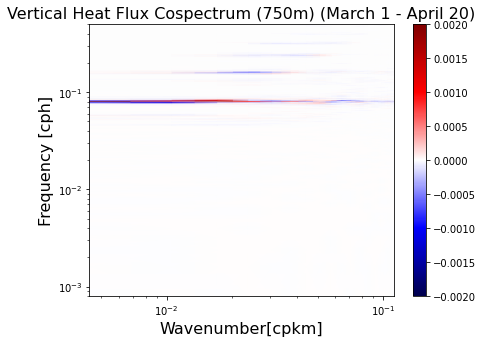

In [67]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs = plt.pcolormesh(kisop45_w, omp45_w, (Cp*rhoConst*1*Eisop45_w*kisop45_w[None,...]*omp45_w[...,None]), shading='gouraud', cmap='seismic')#, norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Heat Flux Cospectrum (750m) (March 1 - April 20)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([-0.002, 0.002])
plt.colorbar()
plt.show()

$ K \times \omega \times Re\big[\rho C_p \hat{W}' \hat{T}'\big]$ - 3month period split into 2 periods,  5 windows (Bartlett's method, not Welch's)

Does the spatial scale make any sense?

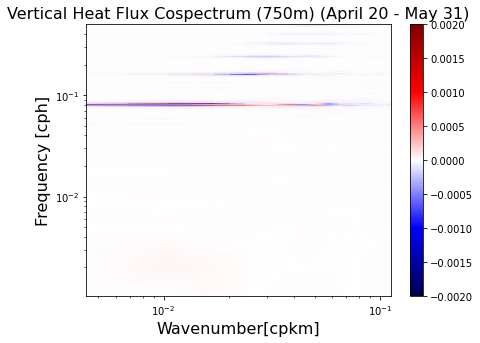

In [68]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs = plt.pcolormesh(kisop45_s, omp45_s, (Cp*rhoConst*1*Eisop45_s*kisop45_s[None,...]*omp45_s[...,None]), shading='gouraud', cmap='seismic')#, norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Heat Flux Cospectrum (750m) (April 20 - May 31)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([-0.002,0.002])
plt.colorbar()
plt.show()

Let me create a section for checking out the KE spectrum. That will go below here and I will calculate those spectra

 Patrice recommends trying to look at SSH first. Let's also try Parseval's theorem with super simple spectra.

In [69]:
Nx = 1003
dx = np.random.rand()
#da = xr.DataArray(np.random.rand(Nx) + 1j * np.random.rand(Nx), dims="x", coords={"x": dx * (np.arange(-Nx // 2, -Nx // 2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))},)
#db = xr.DataArray(np.random.rand(Nx) + 1j*np.random.rand(Nx), dims="x", coords={"x":dx * (np.arange(-Nx//2, -Nx//2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))})
da = xr.DataArray(np.random.rand(Nx) , dims="x", coords={"x": dx * (np.arange(-Nx // 2, -Nx // 2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))},)
db = xr.DataArray(np.random.rand(Nx) , dims="x", coords={"x":dx * (np.arange(-Nx//2, -Nx//2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))})
da2 = xrft.detrend(da, "x", detrend_type='linear')
db2 = xrft.detrend(db, "x", detrend_type='linear')
win, da3 = xrft.xrft._apply_window(da2, "x", window_type='tukey')
_, db3 = xrft.xrft._apply_window(db2, "x", window_type='tukey')


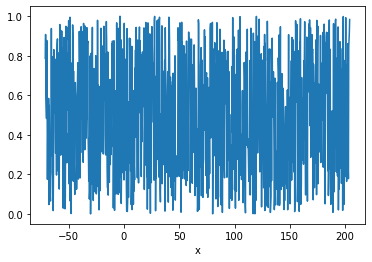

In [70]:
%matplotlib inline
da.plot()

In [71]:
FT = xrft.dft(db3, dim="x", real_dim="x", true_amplitude=True, truncate=True)
#npt.assert_almost_equal(
        #(np.abs(da) ** 2).sum() * dx, (np.abs(FT) ** 2).sum() * FT["freq_x"].spacing
           #            )
#FT2 = xrft.dft(db, dim="x", true_phase=True, true_amplitude=True, truncate=True, window='tukey', detrend='linear')
#CS = xrft.cross_spectrum(db, db, dim='x', real_dim = 'x', true_amplitude=True, truncate=True, window='tukey', window_correction=True, detrend='linear')
ps = xrft.power_spectrum(db3, dim="x", real_dim="x", true_amplitude=True, truncate=True)
FPS = FT*np.conj(FT)#np.abs(FT)**2.0

f = np.full(FPS["freq_x"].size, 2.0)
if FPS["freq_x"].size % 2 == 1:
    f[0], f[-1] = 1.0, 1.0
else:
    f[0] = 1.0
FPS =FPS *xr.DataArray(f, dims="freq_x", coords= FT.coords)



In [72]:
Normx = (np.abs(db3)**2).sum() * dx
Fnormx = (FPS).sum() * (FT["freq_x"].spacing)
#CSN = np.abs(CS.sum())
Pnormx = ps.sum() #SO DEFINITELY USE POWER SPECTRUM IN THE FUTURE. BUT WITH PLOTTING POWER SPECTRUM, DIVIDE OUT A FACTOR OF DX

In [73]:
np.abs((Fnormx - Normx) / Normx)

<xarray.DataArray ()>
array(1.34722563e-14)

In [74]:
np.abs((Pnormx - Normx) / Normx)

<xarray.DataArray ()>
array(1.34722563e-14)

In [75]:
np.abs((Fnormx - Pnormx) / Pnormx)

<xarray.DataArray ()>
array(0.)

In [76]:
#here I will write code to do my own cross spectrum calculation 
#first, I want to detrend the output
Nx = 1003
dx = np.random.rand()
#da = xr.DataArray(np.random.rand(Nx) + 1j * np.random.rand(Nx), dims="x", coords={"x": dx * (np.arange(-Nx // 2, -Nx // 2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))},)
#db = xr.DataArray(np.random.rand(Nx) + 1j*np.random.rand(Nx), dims="x", coords={"x":dx * (np.arange(-Nx//2, -Nx//2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))})
da = xr.DataArray(np.random.rand(Nx) , dims="x", coords={"x": dx * (np.arange(-Nx // 2, -Nx // 2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))},)
db = xr.DataArray(np.random.rand(Nx) , dims="x", coords={"x":dx * (np.arange(-Nx//2, -Nx//2 + Nx) + np.random.randint(-Nx // 2, Nx // 2))})
da_d = xrft.detrend(da, "x", detrend_type='linear')
db_d = xrft.detrend(db, "x", detrend_type='linear')
l = da_d.x.size
#second, I want to window the output
awin, da_dw = xrft.xrft._apply_window(da_d, "x", window_type='hann')
bwin, db_dw = xrft.xrft._apply_window(db_d, "x", window_type='hann')
#third, I take the real Fourier transform
da_hat = xrft.xrft.fft(da_dw, dim = "x", real_dim="x", true_phase = True, true_amplitude = True, truncate = True ) 
dk = da_hat["freq_x"].spacing
db_hat = xrft.xrft.fft(db_dw, dim = "x", real_dim="x", true_phase = True, true_amplitude = True, truncate = True ) 
#fourth, I need to combine the two spectra and appropriately normalize (window correction, 1/L I believe as well)
db_hat_star = np.conj(db_hat)
db_dw_star = np.conj(db_dw)
cospec = da_hat * db_hat_star

f = np.full(cospec.freq_x.size, 2.0)

if cospec.freq_x.size % 2 == 0:
    f[0], f[-1] = 1.0, 1.0
else:
    f[0] = 1.0
cospec = cospec*xr.DataArray(f, dims="freq_x", coords=cospec["freq_x"].coords)



In [77]:
k_norm = (np.real(cospec)*dk**2).sum() * (1/(awin*bwin).mean())
r_norm = (da_dw *np.conj(db_dw)*dx).sum() * (1/(awin*bwin).mean())

In [78]:
crosspec = xrft.cross_spectrum(da_dw, db_dw, dim="x", real_dim="x",true_phase = True, true_amplitude=True, truncate=True)


In [79]:
(np.real(crosspec.sum())/(awin*bwin).mean()*dk - r_norm) / (r_norm)

<xarray.DataArray ()>
array(-1.00004606)

In [80]:
np.real(crosspec.sum())/(awin*bwin).mean()

<xarray.DataArray ()>
array(0.00092934)

In [81]:
r_norm

<xarray.DataArray ()>
array(-0.09212785)

In [82]:
k_norm

<xarray.DataArray ()>
array(8.89886571e-05)

In [83]:
ps = xrft.power_spectrum(db3, dim="x", real_dim="x", true_amplitude=True, truncate=True)
cs = xrft.cross_spectrum(db3, db3, dim="x", real_dim="x",true_phase = True, true_amplitude=True, truncate=True)
((ps-cs)).sum()/(cs.sum())

<xarray.DataArray ()>
array(-3.10552093e-17+0.j)

UPDATES FROM HECTOR MEETING:

COPY XRFT'S CODE AND SEE IF YOU CAN FIX IT


Things to check with Hector:

1. With xrft, spectra matches Parseval theorem unless I do the real_fft. In which case, it doesn't work so well. But this could just be due to whatever transformation the real dim does.
2. WIndow functions and detrending make it harder to get a good match. Do this separately.
3. I don't need a lot of normalization to get Parseval's to work in 1D
4. Should the size of the data matter?
5. Is the approximation for inner product of different functions worse than same function?

In [84]:
win,_ = xrft.xrft._apply_window(Theta15_reg3_w,['xdim','ydim','time'], window_type='tukey')
win3,_ = xrft.xrft._apply_window(Theta15_reg3_w,['xdim'], window_type='tukey')
win2,_ = xrft.xrft._apply_window(Theta15_reg3_w,['ydim'], window_type='tukey')
win1,_ = xrft.xrft._apply_window(Theta15_reg3_w,['time'], window_type='tukey')

In [85]:
(win**2).mean()

<xarray.DataArray ()>
array(0.32495115)

In [86]:
((win1*win2*win3)**2).mean()

<xarray.DataArray ()>
array(0.32495115)

Make it a goal to figure out the depth of integration by the time you get to Caltech!!

In [87]:
Theta15_reg3_w[:,:,0:-1]

<xarray.DataArray (time: 1250, xdim: 300, ydim: 374)>
array([[[ 5.94091617e-02,  5.89431520e-02,  7.66198883e-02, ...,
         -5.07593243e-01, -3.96838526e-01, -3.64847093e-01],
        [ 5.42702583e-02,  5.38042486e-02,  6.09208111e-02, ...,
         -4.92327304e-01, -3.78997192e-01, -3.58199849e-01],
        [ 4.66334841e-02,  4.61674744e-02,  4.36178691e-02, ...,
         -4.89000011e-01, -3.67369486e-01, -3.59249479e-01],
        ...,
        [-1.64914242e+00, -1.64960843e+00, -1.60991840e+00, ...,
          1.77141579e-01,  2.35416767e-01,  2.73123584e-01],
        [-1.56516101e+00, -1.56562702e+00, -1.54659986e+00, ...,
         -1.19298045e-03,  1.02324690e-01,  2.12588707e-01],
        [-1.10143221e+00, -1.10189822e+00, -1.11699056e+00, ...,
         -2.44692003e-02,  1.18137719e-01,  2.66674007e-01]],

       [[ 5.87928739e-02,  5.83350510e-02,  8.29430740e-02, ...,
         -4.97077894e-01, -3.88832773e-01, -3.61339433e-01],
        [ 5.29350623e-02,  5.24772394e-02,  6.49956568e-02, ...,
         -4.84614349e-01, -3.72359977e-01, -3.54786916e-01],
        [ 4.44607171e-02,  4.40028943e-02,  4.52485351e-02, ...,
         -4.83079537e-01, -3.61704589e-01, -3.55875338e-01],
...
        [-3.60445342e-01, -3.60023679e-01, -3.19367191e-01, ...,
          4.46419196e-01,  4.31395119e-01,  4.06398610e-01],
        [-5.04490455e-01, -5.04068792e-01, -4.43363991e-01, ...,
          5.17968147e-01,  5.00884808e-01,  4.83248030e-01],
        [-5.50374818e-01, -5.49953155e-01, -5.65432769e-01, ...,
          5.40307264e-01,  4.97645472e-01,  4.35996420e-01]],

       [[-3.12058673e-01, -3.11631287e-01, -1.64965519e-01, ...,
         -2.92764450e-01, -3.06463605e-01, -2.93393064e-01],
        [-3.08241021e-01, -3.07813635e-01, -1.86647444e-01, ...,
         -3.48048951e-01, -3.28799689e-01, -2.60030284e-01],
        [-2.80261518e-01, -2.79834132e-01, -2.13556916e-01, ...,
         -3.37576180e-01, -2.64403599e-01, -1.28155544e-01],
        ...,
        [-3.52978866e-01, -3.52551480e-01, -3.12279707e-01, ...,
          4.41806889e-01,  4.23995062e-01,  3.94482750e-01],
        [-5.01631438e-01, -5.01204052e-01, -4.42829851e-01, ...,
          5.13705584e-01,  4.97048361e-01,  4.79705712e-01],
        [-5.29701354e-01, -5.29273968e-01, -5.46447366e-01, ...,
          5.48962759e-01,  5.10130443e-01,  4.50055044e-01]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.247e+03 1.248e+03 1.249e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.65e+03 1.655e+03 1.659e+03

In [88]:
Theta15_reg2_w = xrft.detrend(Theta15_reg_w, dim = ['time'], detrend_type = 'linear')
W15_reg2_w = xrft.detrend(W15_reg_w, dim = 'time', detrend_type = 'linear')
Theta15_reg3_w = xrft.detrend(Theta15_reg2_w, dim = ['xdim','ydim'], detrend_type = 'linear')[:,:,0:-1]
W15_reg3_w = xrft.detrend(W15_reg2_w, dim = ['xdim','ydim'], detrend_type = 'linear')[:,:,0:-1]

Lx_s = Theta15_reg3_s.xdim.size
Ly_s = Theta15_reg3_s.ydim.size
Lt_s = Theta15_reg3_s.time.size

dx_s = Theta15_reg3_s.xdim.diff('xdim').mean()
dy_s = Theta15_reg3_s.ydim.diff('ydim').mean()
dt_s = Theta15_reg3_s.time.diff('time').mean()


In [99]:
Th = Theta15_reg3_w.values
W = W15_reg3_w.values
Th = np.swapaxes(Th, 0, 2)
W = np.swapaxes(W, 0, 2)
Th = np.swapaxes(Th, 0, 1)
W = np.swapaxes(W, 0, 1)

In [ ]:
W.shape

In [100]:
d3 = Theta15_reg3_w["time"].diff("time")[0]
d1 = Theta15_reg3_w["xdim"].diff("xdim")[0]
d2 = Theta15_reg3_w["ydim"].diff("ydim")[0]

In [ ]:
1/(2*d2)

In [117]:
crosspec = np.real(xrft.cross_spectrum(Theta15_reg3_w, W15_reg3_w , dim=["xdim","ydim","time"], true_phase = True, true_amplitude=True, window="hann")).sortby(["freq_xdim","freq_ydim"])
crosspec2 = np.real(xrft.cross_spectrum(Theta15_reg3_w, W15_reg3_w , dim=["xdim","ydim","time"], real_dim = "time",true_amplitude=True, window="hann")).sortby(["freq_xdim","freq_ydim"])


In [102]:
import co_spec

test, f1,f2,f3,df1,df2,df3 = co_spec.spec_est3(Th, W, d1.values,d2.values,d3.values)

before fftn
300 374 1250
0.22482232043881828
0.11241116021940924


In [119]:
(crosspec2.sum() - 2*test.sum()) / 2*test.sum()

<xarray.DataArray ()>
array(-343.20646631)

In [114]:
test.sum()

855.3796800350855

In [113]:
Hector_cospec = xr.DataArray(test, dims=["freq_time", "freq_xdim", "freq_ydim"], coords=[f3, f1,f2])

ValueError: conflicting sizes for dimension 'freq_time': length 300 on the data but length 626 on coordinate 'freq_time'

In [ ]:
crosspec2.freq_ydim.diff("freq_ydim").mean()

In [ ]:
1 / (d2.values*375)

In [ ]:
Hector_cospec.freq_ydim.diff("freq_ydim").mean()

In [ ]:
(Hector_cospec.freq_ydim.values - crosspec2.freq_ydim.values)

In [ ]:
Qp15_w_iso = isotropize(np.real(crosspec2.sortby(["freq_xdim","freq_ydim"])), ['freq_xdim', 'freq_ydim'], 'freq_time')  / (Twin_15_w*Wwin_15_w).mean()
Qp15_w_iso_h = isotropize(np.real(Hector_cospec), ['freq_xdim', 'freq_ydim'], 'freq_time')  / (Twin_15_w*Wwin_15_w).mean()

In [ ]:
dkx = crosspec2.sortby(["freq_xdim","freq_ydim"])["freq_xdim"].diff("freq_xdim").mean()
dky = crosspec2.sortby(["freq_xdim","freq_ydim"])["freq_ydim"].diff("freq_ydim").mean()
dom = crosspec2.sortby(["freq_xdim","freq_ydim"])["freq_time"].diff("freq_time").mean()
dkxh = Hector_cospec["freq_xdim"].diff("freq_xdim").mean()
dkyh = Hector_cospec["freq_ydim"].diff("freq_ydim").mean()
domh = Hector_cospec["freq_time"].diff("freq_time").mean()

In [ ]:
A = crosspec2.sum()*dkx*dky*dom
B = Hector_cospec.sum()*dkxh*dkyh*domh

In [ ]:
dkxh*dkyh*domh

In [ ]:
dkx*dky*dom

In [ ]:
(A-B)/B

In [ ]:
(Qp15_w_iso.sum()*Qp15_w_iso["kr"].diff("kr").mean() - Qp15_w_iso_h.sum()*Qp15_w_iso_h["kr"].diff("kr").mean()) / (Qp15_w_iso_h.sum() * Qp15_w_iso_h["kr"].diff("kr").mean())

In [ ]:
Qp15_w_iso["freq_time"].diff("freq_time").mean()

In [ ]:
Qp15_w_iso_h["freq_time"].diff("freq_time").mean()

My conclusion here is that the two codes - cross_spec and spec_est3 comparably satisfy Plancherel's theorem. The factor of two is strange - it tells me that something weird is happening. But really I need to make the plots and see if I can get the correct scaling. I suspect if Plancherel's theorem really is a good test, then we shoud be fine. (1/15)

So the two spectra do appear to be comparable. But the rfftn used in cross_spectrum is strange compared to that used in Hector's. And when you turn on real_dim, the coordinates appear to be absolutely fucked. What the hell is happenning? It seems like cross_spectrum could be the key. But, real_dim is proving to be more and more confusing. (1/16)

The "ydim" has different coordinates in Hector's and my versions. Are the fft's even doing the same thing? They must not be ...

In [98]:
fft_test = np.real(xrft.fft(Theta15_reg3_w, dim=["xdim","ydim","time"], shift=True))

In [94]:
compare = np.real(np.fft.rfftn(Theta15_reg3_w.values))

In [97]:
compare.shape

(1250, 300, 188)

In [ ]:
fft_test

In [ ]:
dy = Theta15_reg3_w.ydim.diff('ydim').mean()
dx = Theta15_reg3_w.xdim.diff('xdim').mean()

In [ ]:
dx

In [ ]:
fft_test["freq_ydim"].diff("freq_ydim").mean()

In [ ]:
1 / (2*dx.values)

In [ ]:
A = xrft.xrft._freq([300,375],[2,4] , None, True)

In [ ]:
A[1]

In [ ]:
(A[1] - np.arange(-1/(2*4), 1/(2*4), 1 / (376*4))).sum()

In [ ]:
np.arange(-1/(2*4), 1/(2*4), 1/(374*4)).shape